In [ ]:
"""
Hybrid EEG Foundation Model - Data Exploration Script for Google Colab
====================================================================

This script combines the power of standard libraries (eegdash, braindecode) with
custom analysis capabilities for comprehensive EEG data exploration.

Libraries Used:
- eegdash: Competition data loading and caching
- braindecode: EEG-specific preprocessing and model utilities
- MNE: Advanced signal processing and visualization
- Custom: Our specialized analysis and gentle preprocessing

Usage in Google Colab:
1. Mount Google Drive
2. Install required packages
3. Run sections sequentially for comprehensive EDA

Author: Adolfo Ramirez-Aristizabal
"""

# SECTION 1: SETUP AND INSTALLATION (Google Colab)

In [1]:
# Install competition-specific packages for Google Colab

!pip install eegdash braindecode mne>=1.6.0 plotly>=5.17.0 einops>=0.7.0


# Mount Google Drive (uncomment for Colab)
"""
from google.colab import drive
drive.mount('/content/drive')

# Navigate to project directory (adjust path as needed)
import os
project_path = '/content/drive/My Drive/My_Path/'
os.chdir(project_path)
print(f"Current directory: {os.getcwd()}")
"""

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.9.0 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.9.0 which is incompatible.


'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n\n# Navigate to project directory (adjust path as needed)\nimport os\nproject_path = \'/content/drive/My Drive/Neuro_Foundation_Model/Neurips_25_EEG_Foundation_Challenge\'\nos.chdir(project_path)\nprint(f"Current directory: {os.getcwd()}")\n'

# SECTION 2: IMPORT LIBRARIES

In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Competition libraries
from eegdash.dataset import EEGChallengeDataset
from braindecode.preprocessing import preprocess, Preprocessor, create_windows_from_events
from braindecode.datasets import BaseConcatDataset
from braindecode.models import EEGNeX

# EEG processing
import mne
from scipy import signal
from scipy.stats import pearsonr, entropy

# Deep learning utilities
import torch
from torch.utils.data import DataLoader
from einops import rearrange, reduce

# Configure plotting and MNE
plt.style.use('default')
sns.set_palette("husl")
mne.set_log_level('WARNING')

print("All libraries imported successfully!")
print("Ready for hybrid EEG analysis with standard + custom capabilities")

All libraries imported successfully!
Ready for hybrid EEG analysis with standard + custom capabilities


# SECTION 3: DATA LOADING WITH EEGDASH

In [3]:
def load_competition_data(task="contrastChangeDetection", release="R5", mini=True, cache_dir="./data"):
    """
    Load competition data using eegdash library

    Parameters:
    - task: Competition task name
    - release: Data release (R5 for validation, others for training)
    - mini: True for small subset, False for full dataset
    - cache_dir: Local caching directory
    """
    print("Loading Competition Data with EEGDash")
    print("=" * 60)

    try:
        # Load dataset
        print(f"Loading task: {task}, release: {release}, mini: {mini}")
        dataset = EEGChallengeDataset(
            task=task,
            release=release,
            cache_dir=cache_dir,
            mini=mini
        )

        print(f"Dataset loaded successfully!")
        print(f"Total recordings: {len(dataset.datasets)}")
        print(f"Cache directory: {cache_dir}")

        # Inspect first recording
        first_recording = dataset.datasets[0]
        raw = first_recording.raw

        print(f"\nFirst Recording Summary:")
        print(f"  Channels: {raw.info['nchan']}")
        print(f"  Sampling rate: {raw.info['sfreq']} Hz")
        print(f"  Duration: {raw.times[-1]:.1f} seconds")
        print(f"  Data shape: {raw.get_data().shape}")

        return dataset, raw

    except Exception as e:
        print(f"Error loading data: {e}")
        print("Tip: Ensure internet connection for initial download")
        return None, None

def inspect_dataset_structure(dataset):
    """Inspect the structure of loaded dataset"""
    print("\nDATASET STRUCTURE INSPECTION")
    print("-" * 40)

    for i, ds in enumerate(dataset.datasets[:3]):  # First 3 recordings
        raw = ds.raw
        print(f"\nRecording {i+1}:")
        print(f"  Subject: {getattr(ds, 'subject', 'Unknown')}")
        print(f"  Session: {getattr(ds, 'session', 'Unknown')}")
        print(f"  Channels: {raw.info['nchan']}")
        print(f"  Duration: {raw.times[-1]:.1f}s")
        print(f"  Sampling rate: {raw.info['sfreq']} Hz")
        print(f"  Channel names (first 10): {raw.ch_names[:10]}")

        # Check for events/annotations
        if hasattr(raw, 'annotations') and len(raw.annotations) > 0:
            print(f"  Annotations: {len(raw.annotations)} events")
            unique_descriptions = list(set(raw.annotations.description))
            print(f"  Event types: {unique_descriptions[:5]}")  # First 5 types

# SECTION 4: BRAINDECODE PREPROCESSING PIPELINE

In [12]:
def create_braindecode_preprocessing_pipeline(target_sfreq=100, l_freq=0.1, h_freq=50.0):
    """
    Create standardized preprocessing pipeline using braindecode

    Returns list of Preprocessor objects for braindecode.preprocess()
    """
    print("\nCreating Braindecode Preprocessing Pipeline")
    print("-" * 50)

    preprocessors = [
        # 1. Bandpass filter (standard EEG range)
        Preprocessor('filter', l_freq=l_freq, h_freq=h_freq, verbose=False),

        # 2. Notch filter for line noise (60Hz in US)
        Preprocessor('notch_filter', freqs=[60], verbose=False),

        # 3. Resample to target frequency
        Preprocessor('resample', sfreq=target_sfreq, verbose=False),

        # 4. Set average reference (excluding bad channels)
        Preprocessor('set_eeg_reference', ref_channels='average', verbose=False),
    ]

    print("Preprocessing pipeline created:")
    for i, prep in enumerate(preprocessors):
        fn_name = prep.fn if isinstance(prep.fn, str) else prep.fn.__name__
        print(f"  {i+1}. {fn_name}: {prep.kwargs}")

    return preprocessors

def apply_braindecode_preprocessing(dataset, preprocessors):
    """Apply braindecode preprocessing to dataset"""
    print("\nApplying Braindecode Preprocessing...")

    try:
        # Apply preprocessing
        preprocess(dataset, preprocessors, n_jobs=1)
        print("Preprocessing completed successfully!")

        # Inspect results
        first_raw = dataset.datasets[0].raw
        print(f"\nPost-preprocessing Summary:")
        print(f"  Channels: {first_raw.info['nchan']}")
        print(f"  Sampling rate: {first_raw.info['sfreq']} Hz")
        print(f"  Duration: {first_raw.times[-1]:.1f} seconds")
        print(f"  Data shape: {first_raw.get_data().shape}")

        return True

    except Exception as e:
        print(f"Preprocessing failed: {e}")
        return False

# SECTION 5: ENHANCED SIGNAL ANALYSIS (HYBRID APPROACH)

In [5]:
def analyze_signal_quality_hybrid(dataset, channel_analysis=True):
    """
    Hybrid signal quality analysis combining braindecode data with custom analysis
    """
    print("\nHYBRID SIGNAL QUALITY ANALYSIS")
    print("=" * 50)

    all_recordings_stats = []

    for i, ds in enumerate(dataset.datasets):
        raw = ds.raw
        eeg_data = raw.get_data()  # Shape: (n_channels, n_samples)
        ch_names = raw.ch_names

        print(f"\nRecording {i+1} Analysis:")
        print(f"  Shape: {eeg_data.shape}")
        print(f"  Sampling rate: {raw.info['sfreq']} Hz")

        # Basic statistics
        stats = {
            'recording': i+1,
            'n_channels': eeg_data.shape[0],
            'n_samples': eeg_data.shape[1],
            'duration': eeg_data.shape[1] / raw.info['sfreq'],
            'sfreq': raw.info['sfreq'],
            'data_range_min': np.min(eeg_data),
            'data_range_max': np.max(eeg_data),
            'overall_std': np.std(eeg_data),
            'nan_count': np.sum(np.isnan(eeg_data)),
            'inf_count': np.sum(np.isinf(eeg_data))
        }

        print(f"  Data range: {stats['data_range_min']:.3f} to {stats['data_range_max']:.3f}")
        print(f"  Overall std: {stats['overall_std']:.3f}")
        print(f"  Quality: NaN={stats['nan_count']}, Inf={stats['inf_count']}")

        # Channel-wise analysis (if requested)
        if channel_analysis and i == 0:  # Only for first recording to save time
            channel_stats = analyze_channel_quality(eeg_data, ch_names)
            stats['channel_stats'] = channel_stats

        all_recordings_stats.append(stats)

    return all_recordings_stats

def analyze_channel_quality(eeg_data, ch_names):
    """Analyze quality of individual channels"""
    print("\n  Channel Quality Analysis:")

    # Channel statistics
    channel_stats = []
    for i, ch_name in enumerate(ch_names):
        ch_data = eeg_data[i, :]
        stats = {
            'channel': ch_name,
            'mean': np.mean(ch_data),
            'std': np.std(ch_data),
            'var': np.var(ch_data),
            'min': np.min(ch_data),
            'max': np.max(ch_data),
            'range': np.max(ch_data) - np.min(ch_data),
            'zero_var': np.var(ch_data) == 0,
            'has_nan': np.any(np.isnan(ch_data)),
            'has_inf': np.any(np.isinf(ch_data))
        }
        channel_stats.append(stats)

    # Identify problem channels
    zero_var_channels = [s['channel'] for s in channel_stats if s['zero_var']]
    nan_channels = [s['channel'] for s in channel_stats if s['has_nan']]
    inf_channels = [s['channel'] for s in channel_stats if s['has_inf']]

    print(f"    Zero variance: {zero_var_channels if zero_var_channels else 'None'}")
    print(f"    NaN channels: {nan_channels if nan_channels else 'None'}")
    print(f"    Inf channels: {inf_channels if inf_channels else 'None'}")

    # High/low variance channels
    variances = [s['var'] for s in channel_stats]
    high_var_threshold = np.percentile(variances, 95)
    low_var_threshold = np.percentile(variances, 5)

    high_var_channels = [s['channel'] for s in channel_stats if s['var'] > high_var_threshold]
    low_var_channels = [s['channel'] for s in channel_stats if s['var'] < low_var_threshold and not s['zero_var']]

    print(f"    High variance (top 5%): {high_var_channels[:5]}")
    print(f"    Low variance (bottom 5%): {low_var_channels[:5]}")

    return pd.DataFrame(channel_stats)

# SECTION 6: FREQUENCY DOMAIN ANALYSIS WITH CUSTOM ENHANCEMENTS

In [6]:
def analyze_frequency_domain_hybrid(dataset, freq_bands=None):
    """
    Hybrid frequency analysis using braindecode data with custom frequency insights
    """
    if freq_bands is None:
        freq_bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 50)
        }

    print("\nHYBRID FREQUENCY DOMAIN ANALYSIS")
    print("=" * 50)

    frequency_results = []

    for i, ds in enumerate(dataset.datasets[:2]):  # Analyze first 2 recordings
        raw = ds.raw
        eeg_data = raw.get_data()
        sfreq = raw.info['sfreq']

        print(f"\nRecording {i+1} Frequency Analysis:")

        # Compute PSD using Welch's method
        freqs, psd = signal.welch(eeg_data, fs=sfreq, nperseg=int(2*sfreq), axis=1)

        # Band power analysis
        band_powers = {}
        for band_name, (low_freq, high_freq) in freq_bands.items():
            freq_mask = (freqs >= low_freq) & (freqs <= high_freq)
            band_power = np.mean(psd[:, freq_mask], axis=1)  # Average across frequencies
            band_powers[band_name] = band_power

            print(f"  {band_name.capitalize()} ({low_freq}-{high_freq} Hz): "
                  f"mean={np.mean(band_power):.2e}, std={np.std(band_power):.2e}")

        # Custom frequency insights (from our original approach)
        freq_insights = analyze_frequency_band_information_custom(
            eeg_data, sfreq, raw.ch_names
        )

        frequency_results.append({
            'recording': i+1,
            'freqs': freqs,
            'psd': psd,
            'band_powers': band_powers,
            'custom_insights': freq_insights
        })

    return frequency_results

def analyze_frequency_band_information_custom(eeg_data, fs, channels):
    """
    Custom frequency band analysis (adapted from our original EDA)
    Analyzes information content and amplitude dominance
    """
    frequency_categories = {
        'Neural_EEG': (0.75, 45),
        'Gamma_Mixed': (30, 90),
        'EMG': (80, min(190, fs//2 - 1)),  # Ensure below Nyquist
        'High_Noise': (180, min(250, fs//2 - 1))
    }

    results = {}

    # Calculate PSD for full spectrum
    freqs, psd = signal.welch(eeg_data, fs=fs, nperseg=1024, axis=1)

    for category_name, (low_freq, high_freq) in frequency_categories.items():
        # Skip if frequency range exceeds Nyquist
        if low_freq >= fs//2:
            continue

        freq_mask = (freqs >= low_freq) & (freqs <= high_freq)
        if not np.any(freq_mask):
            continue

        band_psd = psd[:, freq_mask]

        # Amplitude dominance
        total_power = np.sum(band_psd, axis=1)

        # Information content (Shannon entropy)
        shannon_entropy = []
        for ch_idx in range(band_psd.shape[0]):
            psd_norm = band_psd[ch_idx] / (np.sum(band_psd[ch_idx]) + 1e-12)
            entropy_val = -np.sum(psd_norm * np.log2(psd_norm + 1e-12))
            shannon_entropy.append(entropy_val)

        results[category_name] = {
            'total_power': total_power,
            'mean_power': np.mean(total_power),
            'shannon_entropy': np.array(shannon_entropy),
            'mean_entropy': np.mean(shannon_entropy),
            'freq_range': (low_freq, high_freq)
        }

    return results

# SECTION 7: BRAINDECODE WINDOWING AND PYTORCH INTEGRATION

In [7]:
def create_competition_windows(dataset, window_length=2.0, shift_after_stim=0.5):
    """
    Create windowed data following competition tutorial approach
    """
    print("\nCREATING COMPETITION-STYLE WINDOWS")
    print("=" * 45)

    try:
        # Following the tutorial's approach for stimulus-locked windows
        SFREQ = 100  # Target sampling rate after preprocessing
        EPOCH_LEN_S = window_length
        SHIFT_AFTER_STIM = shift_after_stim
        WINDOW_LEN = window_length

        # Create windows from events (this would need actual event processing)
        # For now, we'll create simple fixed windows as a demonstration

        windowed_datasets = []
        total_windows = 0

        for i, ds in enumerate(dataset.datasets):
            raw = ds.raw
            eeg_data = raw.get_data()
            sfreq = raw.info['sfreq']

            # Create non-overlapping windows
            window_samples = int(window_length * sfreq)
            step_samples = window_samples  # No overlap

            n_windows = (eeg_data.shape[1] - window_samples) // step_samples + 1

            windows = []
            for w in range(n_windows):
                start_idx = w * step_samples
                end_idx = start_idx + window_samples
                window_data = eeg_data[:, start_idx:end_idx]
                windows.append(window_data)

            windowed_datasets.append(np.stack(windows))
            total_windows += n_windows

            print(f"  Recording {i+1}: {n_windows} windows of shape {windows[0].shape}")

        print(f"\nTotal windows created: {total_windows}")
        print(f"Window shape: (n_channels={eeg_data.shape[0]}, n_times={window_samples})")

        return windowed_datasets

    except Exception as e:
        print(f"Window creation failed: {e}")
        return None

def create_pytorch_dataloader(windowed_data, batch_size=32, shuffle=True):
    """Create PyTorch DataLoader from windowed data"""
    print(f"\nCreating PyTorch DataLoader (batch_size={batch_size})")

    # Combine all windows from all recordings
    all_windows = np.concatenate(windowed_data, axis=0)

    # Create dummy labels for demonstration (in real case, extract from events)
    n_windows = all_windows.shape[0]
    dummy_labels = np.random.randn(n_windows, 1)  # Regression targets

    # Convert to PyTorch tensors
    X = torch.tensor(all_windows, dtype=torch.float32)
    y = torch.tensor(dummy_labels, dtype=torch.float32)

    # Create dataset and dataloader
    dataset = torch.utils.data.TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    print(f"DataLoader created:")
    print(f"  Total samples: {len(dataset)}")
    print(f"  Batch size: {batch_size}")
    print(f"  Input shape: {X.shape}")
    print(f"  Label shape: {y.shape}")

    return dataloader

# SECTION 8: BASELINE MODEL COMPARISON

In [8]:
def create_eegneX_baseline(n_chans=129, n_times=200, sfreq=100):
    """Create EEGNeX baseline model for comparison"""
    print("\nCREATING EEGNEX BASELINE MODEL")
    print("=" * 40)

    try:
        model = EEGNeX(
            n_chans=n_chans,
            n_outputs=1,  # Regression
            n_times=n_times,
            sfreq=sfreq
        )

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"EEGNeX Model Created:")
        print(f"  Input shape: (batch, {n_chans}, {n_times})")
        print(f"  Output: 1 (regression)")
        print(f"  Total parameters: {total_params:,}")
        print(f"  Trainable parameters: {trainable_params:,}")

        # Test forward pass
        dummy_input = torch.randn(1, n_chans, n_times)
        with torch.no_grad():
            output = model(dummy_input)
        print(f"  Forward pass test: {dummy_input.shape} → {output.shape}")

        return model

    except Exception as e:
        print(f"Model creation failed: {e}")
        return None

def test_model_with_data(model, dataloader, device='cpu'):
    """Test model with actual data"""
    print(f"\nTesting Model with Data (device={device})")

    model.to(device)
    model.eval()

    try:
        # Get one batch
        batch_X, batch_y = next(iter(dataloader))
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        print(f"  Batch input shape: {batch_X.shape}")
        print(f"  Batch target shape: {batch_y.shape}")

        # Forward pass
        with torch.no_grad():
            predictions = model(batch_X)

        print(f"  Predictions shape: {predictions.shape}")
        print(f"  Sample predictions: {predictions[:3].flatten().cpu().numpy()}")
        print(f"  Sample targets: {batch_y[:3].flatten().cpu().numpy()}")

        # Compute loss
        criterion = torch.nn.MSELoss()
        loss = criterion(predictions, batch_y)
        print(f"  MSE Loss: {loss.item():.4f}")

        print("Model test successful!")
        return True

    except Exception as e:
        print(f"Model test failed: {e}")
        return False

# SECTION 9: COMPREHENSIVE VISUALIZATION SUITE

In [9]:
def create_comprehensive_visualizations(frequency_results, signal_stats):
    """Create comprehensive visualizations of the analysis results"""
    print("\nCREATING COMPREHENSIVE VISUALIZATIONS")
    print("=" * 50)

    # 1. Signal Quality Overview
    create_signal_quality_plots(signal_stats)

    # 2. Frequency Analysis Plots
    create_frequency_analysis_plots(frequency_results)

    # 3. Interactive Plotly Visualizations
    create_interactive_frequency_plots(frequency_results)

def create_signal_quality_plots(signal_stats):
    """Create signal quality visualization plots"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Extract data for plotting
    recordings = [s['recording'] for s in signal_stats]
    durations = [s['duration'] for s in signal_stats]
    data_ranges = [s['data_range_max'] - s['data_range_min'] for s in signal_stats]
    overall_stds = [s['overall_std'] for s in signal_stats]
    n_channels = [s['n_channels'] for s in signal_stats]

    # Plot 1: Duration vs Recording
    axes[0,0].bar(recordings, durations)
    axes[0,0].set_title('Recording Durations')
    axes[0,0].set_xlabel('Recording')
    axes[0,0].set_ylabel('Duration (s)')

    # Plot 2: Data Range vs Recording
    axes[0,1].bar(recordings, data_ranges)
    axes[0,1].set_title('Signal Amplitude Ranges')
    axes[0,1].set_xlabel('Recording')
    axes[0,1].set_ylabel('Amplitude Range')

    # Plot 3: Standard Deviation
    axes[1,0].bar(recordings, overall_stds)
    axes[1,0].set_title('Overall Signal Variability')
    axes[1,0].set_xlabel('Recording')
    axes[1,0].set_ylabel('Standard Deviation')

    # Plot 4: Channel Count
    axes[1,1].bar(recordings, n_channels)
    axes[1,1].set_title('Number of Channels')
    axes[1,1].set_xlabel('Recording')
    axes[1,1].set_ylabel('Channel Count')

    plt.tight_layout()
    plt.show()

def create_frequency_analysis_plots(frequency_results):
    """Create frequency domain analysis plots"""
    if not frequency_results:
        print("No frequency results to plot")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    for i, result in enumerate(frequency_results[:2]):
        # PSD plot
        freqs = result['freqs']
        psd = result['psd']

        # Average PSD across channels
        mean_psd = np.mean(psd, axis=0)

        axes[i, 0].semilogy(freqs, mean_psd)
        axes[i, 0].set_title(f'Recording {i+1}: Average PSD')
        axes[i, 0].set_xlabel('Frequency (Hz)')
        axes[i, 0].set_ylabel('Power (µV²/Hz)')
        axes[i, 0].grid(True, alpha=0.3)

        # Band power comparison
        band_powers = result['band_powers']
        bands = list(band_powers.keys())
        mean_powers = [np.mean(band_powers[band]) for band in bands]

        axes[i, 1].bar(bands, mean_powers)
        axes[i, 1].set_title(f'Recording {i+1}: Band Powers')
        axes[i, 1].set_xlabel('Frequency Band')
        axes[i, 1].set_ylabel('Mean Power')
        axes[i, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

def create_interactive_frequency_plots(frequency_results):
    """Create interactive Plotly visualizations"""
    if not frequency_results:
        print("No frequency results for interactive plots")
        return

    # Create interactive PSD comparison
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Power Spectral Density', 'Band Power Comparison')
    )

    colors = ['blue', 'red', 'green', 'orange']

    for i, result in enumerate(frequency_results):
        freqs = result['freqs']
        psd = result['psd']
        mean_psd = np.mean(psd, axis=0)

        # PSD plot
        fig.add_trace(
            go.Scatter(
                x=freqs, y=mean_psd,
                mode='lines',
                name=f'Recording {i+1}',
                line=dict(color=colors[i % len(colors)])
            ),
            row=1, col=1
        )

        # Band power plot
        band_powers = result['band_powers']
        bands = list(band_powers.keys())
        mean_powers = [np.mean(band_powers[band]) for band in bands]

        fig.add_trace(
            go.Bar(
                x=bands, y=mean_powers,
                name=f'Recording {i+1}',
                marker_color=colors[i % len(colors)],
                opacity=0.7
            ),
            row=1, col=2
        )

    fig.update_xaxes(title_text="Frequency (Hz)", row=1, col=1)
    fig.update_yaxes(title_text="Power (µV²/Hz)", type="log", row=1, col=1)
    fig.update_xaxes(title_text="Frequency Band", row=1, col=2)
    fig.update_yaxes(title_text="Mean Power", row=1, col=2)

    fig.update_layout(height=500, title_text="Interactive Frequency Analysis")
    fig.show()

# SECTION 10: MAIN EXECUTION FUNCTION

In [10]:
def run_hybrid_eda(task="contrastChangeDetection", release="R5", mini=True):
    """
    Run comprehensive hybrid EDA combining standard libraries with custom analysis
    """
    print("STARTING HYBRID EEG DATA EXPLORATION")
    print("=" * 70)
    print(f"Task: {task}")
    print(f"Release: {release}")
    print(f"Mini dataset: {mini}")

    results = {}

    # Step 1: Load data with eegdash
    print("\n" + "="*70)
    print("STEP 1: DATA LOADING")
    dataset, first_raw = load_competition_data(task=task, release=release, mini=mini)
    if dataset is None:
        print("Failed to load data. Stopping analysis.")
        return None

    results['dataset'] = dataset
    results['first_raw'] = first_raw

    # Step 2: Inspect dataset structure
    inspect_dataset_structure(dataset)

    # Step 3: Apply braindecode preprocessing
    print("\n" + "="*70)
    print("STEP 2: BRAINDECODE PREPROCESSING")
    preprocessors = create_braindecode_preprocessing_pipeline()
    preprocessing_success = apply_braindecode_preprocessing(dataset, preprocessors)

    if not preprocessing_success:
        print("Warning: Preprocessing failed, continuing with raw data")

    results['preprocessors'] = preprocessors
    results['preprocessing_success'] = preprocessing_success

    # Step 4: Signal quality analysis
    print("\n" + "="*70)
    print("STEP 3: SIGNAL QUALITY ANALYSIS")
    signal_stats = analyze_signal_quality_hybrid(dataset, channel_analysis=True)
    results['signal_stats'] = signal_stats

    # Step 5: Frequency domain analysis
    print("\n" + "="*70)
    print("STEP 4: FREQUENCY DOMAIN ANALYSIS")
    frequency_results = analyze_frequency_domain_hybrid(dataset)
    results['frequency_results'] = frequency_results

    # Step 6: Create windows for deep learning
    print("\n" + "="*70)
    print("STEP 5: WINDOWING FOR DEEP LEARNING")
    windowed_data = create_competition_windows(dataset)
    if windowed_data:
        dataloader = create_pytorch_dataloader(windowed_data, batch_size=32)
        results['windowed_data'] = windowed_data
        results['dataloader'] = dataloader

    # Step 7: Create baseline model
    print("\n" + "="*70)
    print("STEP 6: BASELINE MODEL CREATION")

    # Get actual data dimensions from preprocessed data
    sample_raw = dataset.datasets[0].raw
    n_chans = sample_raw.info['nchan']
    sfreq = sample_raw.info['sfreq']
    n_times = int(2.0 * sfreq)  # 2 seconds

    baseline_model = create_eegneX_baseline(n_chans=n_chans, n_times=n_times, sfreq=int(sfreq))
    if baseline_model and windowed_data:
        test_success = test_model_with_data(baseline_model, dataloader)
        results['baseline_model'] = baseline_model
        results['model_test_success'] = test_success

    # Step 8: Create visualizations
    print("\n" + "="*70)
    print("STEP 7: COMPREHENSIVE VISUALIZATIONS")
    create_comprehensive_visualizations(frequency_results, signal_stats)

    # Step 9: Summary
    print("\n" + "="*70)
    print("HYBRID EDA COMPLETE!")
    print("=" * 70)

    print(f"\nSUMMARY:")
    print(f"  Recordings analyzed: {len(dataset.datasets)}")
    print(f"  Preprocessing: {'Success' if preprocessing_success else 'Partial'}")
    print(f"  Signal quality: {len(signal_stats)} recordings")
    print(f"  Frequency analysis: {len(frequency_results)} recordings")
    if windowed_data:
        total_windows = sum(len(wd) for wd in windowed_data)
        print(f"  Windows created: {total_windows}")
    if baseline_model:
        print(f"  Baseline model: EEGNeX ready")

    print(f"\nNEXT STEPS:")
    print(f"  1. Experiment with different preprocessing parameters")
    print(f"  2. Implement custom EEG-GPT architecture")
    print(f"  3. Compare performance against EEGNeX baseline")
    print(f"  4. Scale to full dataset (mini=False)")

    return results

# EXAMPLE USAGE

Starting Hybrid EEG Foundation Model EDA
STARTING HYBRID EEG DATA EXPLORATION
Task: contrastChangeDetection
Release: R5
Mini dataset: True

STEP 1: DATA LOADING
Loading Competition Data with EEGDash
Loading task: contrastChangeDetection, release: R5, mini: True
Dataset loaded successfully!
Total recordings: 60
Cache directory: ./data

First Recording Summary:
  Channels: 129
  Sampling rate: 100.0 Hz
  Duration: 349.0 seconds
  Data shape: (129, 34900)

DATASET STRUCTURE INSPECTION
----------------------------------------

Recording 1:
  Subject: Unknown
  Session: Unknown
  Channels: 129
  Duration: 349.0s
  Sampling rate: 100.0 Hz
  Channel names (first 10): ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10']
  Annotations: 75 events
  Event types: [np.str_('left_target'), np.str_('right_buttonPress'), np.str_('contrastTrial_start'), np.str_('left_buttonPress'), np.str_('contrastChangeB1_start')]

Recording 2:
  Subject: Unknown
  Session: Unknown
  Channels: 129
  Duration


Recording 4 Analysis:
  Shape: (129, 26400)
  Sampling rate: 100.0 Hz
  Data range: -0.330 to 0.086
  Overall std: 0.001
  Quality: NaN=0, Inf=0



Recording 5 Analysis:
  Shape: (129, 23800)
  Sampling rate: 100.0 Hz
  Data range: -0.008 to 0.003
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 6 Analysis:
  Shape: (129, 25300)
  Sampling rate: 100.0 Hz
  Data range: -0.329 to 0.329
  Overall std: 0.004
  Quality: NaN=0, Inf=0



Recording 7 Analysis:
  Shape: (129, 32400)
  Sampling rate: 100.0 Hz
  Data range: -0.285 to 0.278
  Overall std: 0.004
  Quality: NaN=0, Inf=0



Recording 8 Analysis:
  Shape: (129, 30400)
  Sampling rate: 100.0 Hz
  Data range: -0.388 to 0.201
  Overall std: 0.008
  Quality: NaN=0, Inf=0



Recording 9 Analysis:
  Shape: (129, 28700)
  Sampling rate: 100.0 Hz
  Data range: -0.368 to 0.241
  Overall std: 0.004
  Quality: NaN=0, Inf=0



Recording 10 Analysis:
  Shape: (129, 24000)
  Sampling rate: 100.0 Hz
  Data range: -0.140 to 0.346
  Overall std: 0.003
  Quality: NaN=0, Inf=0



Recording 11 Analysis:
  Shape: (129, 23600)
  Sampling rate: 100.0 Hz
  Data range: -0.212 to 0.361
  Overall std: 0.002
  Quality: NaN=0, Inf=0



Recording 12 Analysis:
  Shape: (129, 23400)
  Sampling rate: 100.0 Hz
  Data range: -0.025 to 0.027
  Overall std: 0.001
  Quality: NaN=0, Inf=0



Recording 13 Analysis:
  Shape: (129, 31800)
  Sampling rate: 100.0 Hz
  Data range: -0.368 to 0.292
  Overall std: 0.003
  Quality: NaN=0, Inf=0



Recording 14 Analysis:
  Shape: (129, 25500)
  Sampling rate: 100.0 Hz
  Data range: -0.378 to 0.295
  Overall std: 0.006
  Quality: NaN=0, Inf=0



Recording 15 Analysis:
  Shape: (129, 26100)
  Sampling rate: 100.0 Hz
  Data range: -0.063 to 0.092
  Overall std: 0.001
  Quality: NaN=0, Inf=0



Recording 16 Analysis:
  Shape: (129, 23100)
  Sampling rate: 100.0 Hz
  Data range: -0.082 to 0.021
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 17 Analysis:
  Shape: (129, 23700)
  Sampling rate: 100.0 Hz
  Data range: -0.010 to 0.010
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 18 Analysis:
  Shape: (129, 23700)
  Sampling rate: 100.0 Hz
  Data range: -0.335 to 0.295
  Overall std: 0.003
  Quality: NaN=0, Inf=0



Recording 19 Analysis:
  Shape: (129, 32400)
  Sampling rate: 100.0 Hz
  Data range: -0.009 to 0.007
  Overall std: 0.002
  Quality: NaN=0, Inf=0



Recording 20 Analysis:
  Shape: (129, 22100)
  Sampling rate: 100.0 Hz
  Data range: -0.007 to 0.031
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 21 Analysis:
  Shape: (129, 33400)
  Sampling rate: 100.0 Hz
  Data range: -0.003 to 0.009
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 22 Analysis:
  Shape: (129, 52300)
  Sampling rate: 100.0 Hz
  Data range: -0.268 to 0.284
  Overall std: 0.002
  Quality: NaN=0, Inf=0



Recording 23 Analysis:
  Shape: (129, 18200)
  Sampling rate: 100.0 Hz
  Data range: -0.076 to 0.036
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 24 Analysis:
  Shape: (129, 18300)
  Sampling rate: 100.0 Hz
  Data range: -0.282 to 0.297
  Overall std: 0.004
  Quality: NaN=0, Inf=0



Recording 25 Analysis:
  Shape: (129, 28600)
  Sampling rate: 100.0 Hz
  Data range: -0.316 to 0.325
  Overall std: 0.003
  Quality: NaN=0, Inf=0



Recording 26 Analysis:
  Shape: (129, 23900)
  Sampling rate: 100.0 Hz
  Data range: -0.392 to 0.329
  Overall std: 0.006
  Quality: NaN=0, Inf=0



Recording 27 Analysis:
  Shape: (129, 23500)
  Sampling rate: 100.0 Hz
  Data range: -0.332 to 0.330
  Overall std: 0.006
  Quality: NaN=0, Inf=0



Recording 28 Analysis:
  Shape: (129, 24900)
  Sampling rate: 100.0 Hz
  Data range: -0.352 to 0.205
  Overall std: 0.002
  Quality: NaN=0, Inf=0



Recording 29 Analysis:
  Shape: (129, 48500)
  Sampling rate: 100.0 Hz
  Data range: -0.410 to 0.243
  Overall std: 0.002
  Quality: NaN=0, Inf=0



Recording 30 Analysis:
  Shape: (129, 32200)
  Sampling rate: 100.0 Hz
  Data range: -0.059 to 0.008
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 31 Analysis:
  Shape: (129, 29000)
  Sampling rate: 100.0 Hz
  Data range: 0.000 to 0.000
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 32 Analysis:
  Shape: (129, 32800)
  Sampling rate: 100.0 Hz
  Data range: 0.000 to 0.000
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 33 Analysis:
  Shape: (129, 37900)
  Sampling rate: 100.0 Hz
  Data range: 0.000 to 0.000
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 34 Analysis:
  Shape: (129, 19700)
  Sampling rate: 100.0 Hz
  Data range: -0.033 to 0.025
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 35 Analysis:
  Shape: (129, 15400)
  Sampling rate: 100.0 Hz
  Data range: -0.195 to 0.022
  Overall std: 0.001
  Quality: NaN=0, Inf=0



Recording 36 Analysis:
  Shape: (129, 27300)
  Sampling rate: 100.0 Hz
  Data range: -0.006 to 0.003
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 37 Analysis:
  Shape: (129, 23800)
  Sampling rate: 100.0 Hz
  Data range: -0.008 to 0.007
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 38 Analysis:
  Shape: (129, 27200)
  Sampling rate: 100.0 Hz
  Data range: -0.001 to 0.004
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 39 Analysis:
  Shape: (129, 24000)
  Sampling rate: 100.0 Hz
  Data range: -0.006 to 0.017
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 40 Analysis:
  Shape: (129, 61000)
  Sampling rate: 100.0 Hz
  Data range: -0.091 to 0.084
  Overall std: 0.001
  Quality: NaN=0, Inf=0



Recording 41 Analysis:
  Shape: (129, 23500)
  Sampling rate: 100.0 Hz
  Data range: -0.002 to 0.005
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 42 Analysis:
  Shape: (129, 22600)
  Sampling rate: 100.0 Hz
  Data range: -0.002 to 0.002
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 43 Analysis:
  Shape: (129, 27500)
  Sampling rate: 100.0 Hz
  Data range: -0.012 to 0.016
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 44 Analysis:
  Shape: (129, 25000)
  Sampling rate: 100.0 Hz
  Data range: -0.009 to 0.008
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 45 Analysis:
  Shape: (129, 24200)
  Sampling rate: 100.0 Hz
  Data range: -0.007 to 0.010
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 46 Analysis:
  Shape: (129, 20100)
  Sampling rate: 100.0 Hz
  Data range: -0.084 to 0.017
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 47 Analysis:
  Shape: (129, 35300)
  Sampling rate: 100.0 Hz
  Data range: -0.016 to 0.006
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 48 Analysis:
  Shape: (129, 29800)
  Sampling rate: 100.0 Hz
  Data range: -0.033 to 0.020
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 49 Analysis:
  Shape: (129, 49400)
  Sampling rate: 100.0 Hz
  Data range: -0.002 to 0.003
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 50 Analysis:
  Shape: (129, 39600)
  Sampling rate: 100.0 Hz
  Data range: -0.009 to 0.004
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 51 Analysis:
  Shape: (129, 32900)
  Sampling rate: 100.0 Hz
  Data range: -0.007 to 0.003
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 52 Analysis:
  Shape: (129, 25600)
  Sampling rate: 100.0 Hz
  Data range: -0.003 to 0.003
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 53 Analysis:
  Shape: (129, 26600)
  Sampling rate: 100.0 Hz
  Data range: -0.336 to 0.275
  Overall std: 0.005
  Quality: NaN=0, Inf=0



Recording 54 Analysis:
  Shape: (129, 23800)
  Sampling rate: 100.0 Hz
  Data range: -0.233 to 0.255
  Overall std: 0.001
  Quality: NaN=0, Inf=0



Recording 55 Analysis:
  Shape: (129, 23700)
  Sampling rate: 100.0 Hz
  Data range: -0.001 to 0.001
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 56 Analysis:
  Shape: (129, 32100)
  Sampling rate: 100.0 Hz
  Data range: -0.046 to 0.083
  Overall std: 0.001
  Quality: NaN=0, Inf=0



Recording 57 Analysis:
  Shape: (129, 27300)
  Sampling rate: 100.0 Hz
  Data range: -0.139 to 0.133
  Overall std: 0.001
  Quality: NaN=0, Inf=0



Recording 58 Analysis:
  Shape: (129, 44500)
  Sampling rate: 100.0 Hz
  Data range: -0.095 to 0.320
  Overall std: 0.001
  Quality: NaN=0, Inf=0



Recording 59 Analysis:
  Shape: (129, 23900)
  Sampling rate: 100.0 Hz
  Data range: -0.013 to 0.018
  Overall std: 0.000
  Quality: NaN=0, Inf=0



Recording 60 Analysis:
  Shape: (129, 25000)
  Sampling rate: 100.0 Hz
  Data range: -0.027 to 0.011
  Overall std: 0.000
  Quality: NaN=0, Inf=0

STEP 4: FREQUENCY DOMAIN ANALYSIS

HYBRID FREQUENCY DOMAIN ANALYSIS

Recording 1 Frequency Analysis:
  Delta (0.5-4 Hz): mean=7.14e-08, std=7.53e-07
  Theta (4-8 Hz): mean=8.22e-09, std=8.97e-08
  Alpha (8-13 Hz): mean=1.42e-09, std=1.50e-08
  Beta (13-30 Hz): mean=3.16e-10, std=3.31e-09
  Gamma (30-50 Hz): mean=6.46e-11, std=6.91e-10

Recording 2 Frequency Analysis:
  Delta (0.5-4 Hz): mean=5.76e-09, std=4.35e-08
  Theta (4-8 Hz): mean=2.96e-10, std=2.31e-09
  Alpha (8-13 Hz): mean=9.15e-11, std=7.44e-10
  Beta (13-30 Hz): mean=2.11e-11, std=1.72e-10
  Gamma (30-50 Hz): mean=4.09e-12, std=2.76e-11

STEP 5: WINDOWING FOR DEEP LEARNING

CREATING COMPETITION-STYLE WINDOWS
  Recording 1: 174 windows of shape (129, 200)
  Recording 2: 200 windows of shape (129, 200)
  Recording 3: 191 windows of shape (129, 200)
  Recording 4: 132 windows of sh

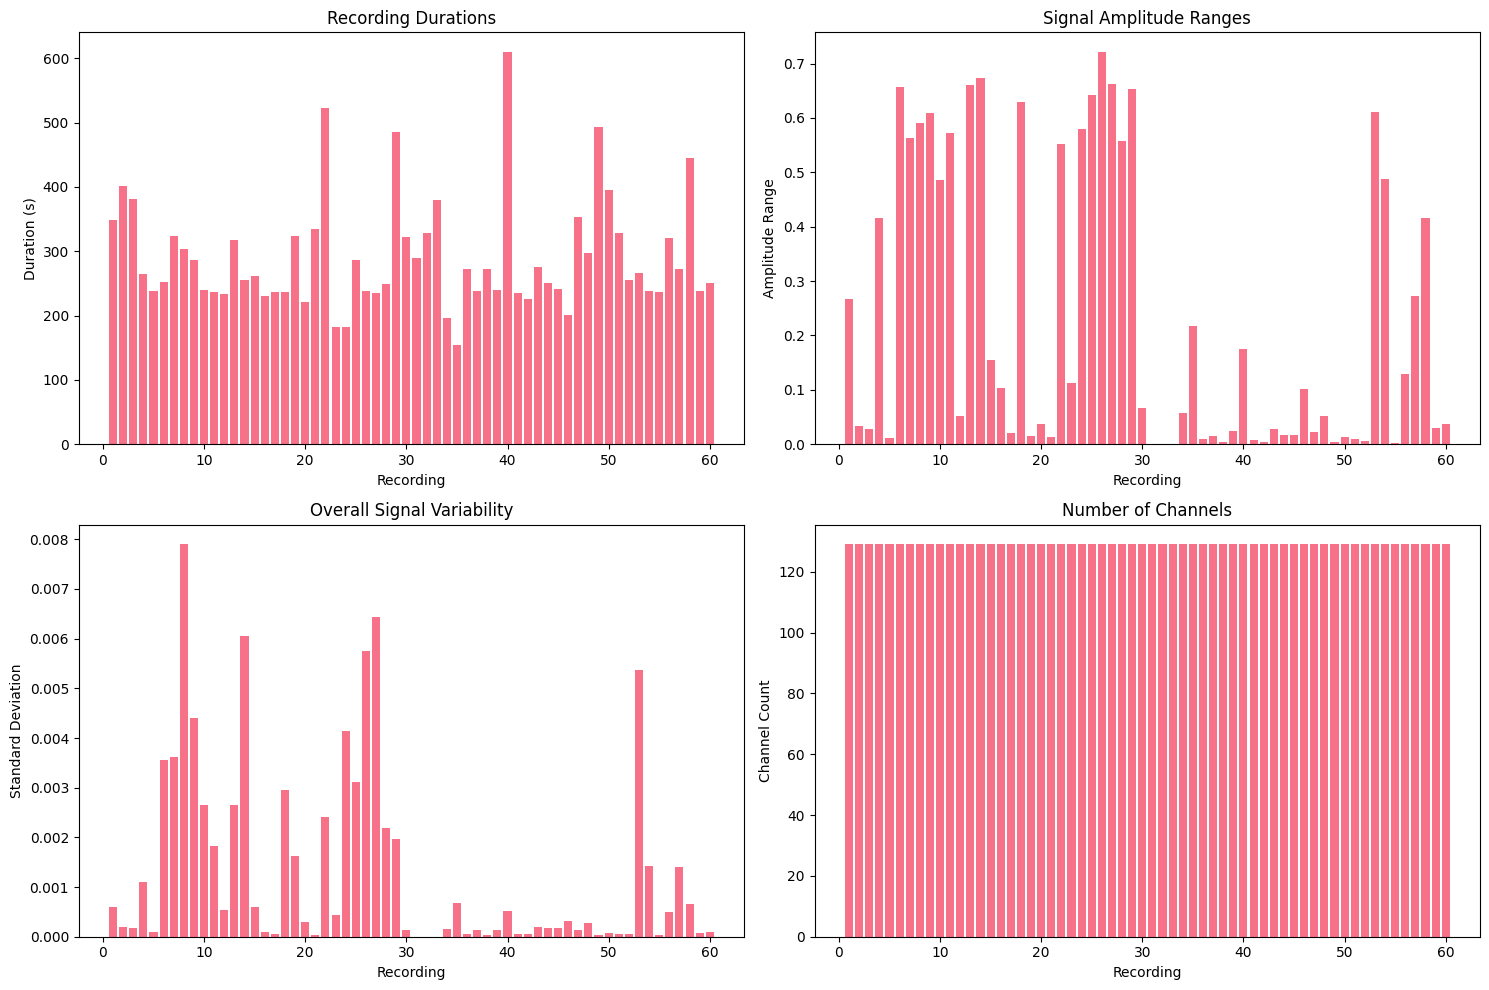

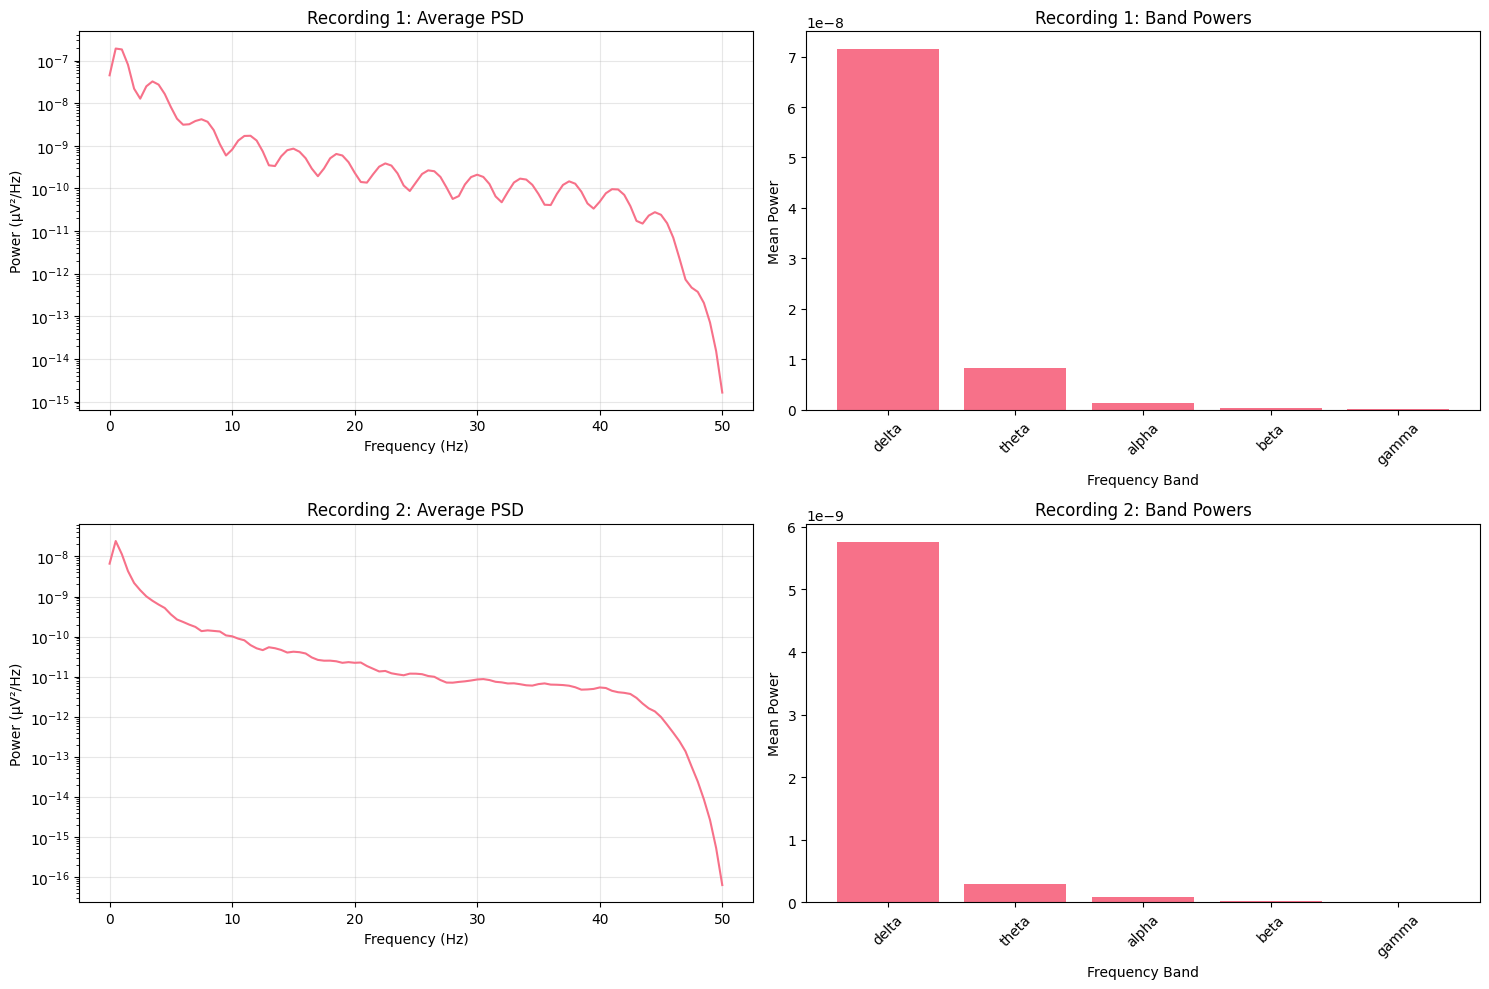


HYBRID EDA COMPLETE!

SUMMARY:
  Recordings analyzed: 60
  Preprocessing: Partial
  Signal quality: 60 recordings
  Frequency analysis: 2 recordings
  Windows created: 8705
  Baseline model: EEGNeX ready

NEXT STEPS:
  1. Experiment with different preprocessing parameters
  2. Implement custom EEG-GPT architecture
  3. Compare performance against EEGNeX baseline
  4. Scale to full dataset (mini=False)

Analysis complete! Results stored in 'results' dictionary.
Available keys: ['dataset', 'first_raw', 'preprocessors', 'preprocessing_success', 'signal_stats', 'frequency_results', 'windowed_data', 'dataloader', 'baseline_model', 'model_test_success']

USAGE EXAMPLES:
# Access loaded dataset
dataset = results['dataset']

# Access PyTorch dataloader
dataloader = results['dataloader']

# Access baseline model
model = results['baseline_model']

# Start training loop
for batch_X, batch_y in dataloader:
    predictions = model(batch_X)
    # ... training code ...


In [13]:
if __name__ == "__main__":
    # Run the comprehensive hybrid EDA
    print("Starting Hybrid EEG Foundation Model EDA")

    # Load and analyze data
    results = run_hybrid_eda(
        task="contrastChangeDetection",
        release="R5",
        mini=True  # Start with mini dataset
    )

    if results:
        print("\nAnalysis complete! Results stored in 'results' dictionary.")
        print("Available keys:", list(results.keys()))

        print("\nUSAGE EXAMPLES:")
        print("# Access loaded dataset")
        print("dataset = results['dataset']")
        print()
        print("# Access PyTorch dataloader")
        print("dataloader = results['dataloader']")
        print()
        print("# Access baseline model")
        print("model = results['baseline_model']")
        print()
        print("# Start training loop")
        print("for batch_X, batch_y in dataloader:")
        print("    predictions = model(batch_X)")
        print("    # ... training code ...")

    else:
        print("Analysis failed. Check internet connection and try again.")